In [5]:
import pandas as pd
import os
from google.colab import drive
import torch

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = '/content/drive/My Drive/nlp'

os.chdir(folder_path)

os.listdir()

['glove.6B.100d.txt',
 'training.csv',
 'test.csv',
 'validation.csv',
 'dataset.csv',
 'glove.6B.100d.word2vec.txt',
 'fine-tune embeddings.ipynb',
 'ml implementations.ipynb',
 'torchmoji.ipynb',
 'DeepMoji.ipynb',
 'train.csv',
 'train1.csv',
 'test1.csv',
 'Untitled0.ipynb',
 '1_dataset_preparation.ipynb',
 '2_task.ipynb',
 'torchmoji_model',
 'task_1_to_7.ipynb']

In [6]:
# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


In [72]:
# pip install wordcloud
# pip install empath
# !pip install gensim
# pip install scikit-learn
# !pip install transformers

In [101]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
from empath import Empath
from sklearn.metrics.pairwise import cosine_similarity
import random
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
from scipy.stats import spearmanr
from gensim.models import FastText
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from gensim.models import KeyedVectors
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score









# Download required NLTK data
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt_tab')
# nltk.download('stopwords')

#Task 1

In [10]:
df = pd.read_csv('dataset.csv')

In [11]:
# functions to clean text, tokenize, count pronouns, and check OOV words
# remove URLs
url_re = re.compile(r'https?://\S+|www\.\S+')

alpha_re = re.compile(r"[^a-zA-Z']")


pronouns = {
    'i','you','he','she','it','we','they',
    'me','him','her','us','them',
    'my','your','his','her','its','our','their',
    'mine','yours','hers','ours','theirs',
    "i'm","you're","he's","she's","we're","they're"
}

# clean and tokenize text

def preprocess_and_tokenize(text):
    text = url_re.sub(' ', text)
    text = text.lower()
    text = alpha_re.sub(' ', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.strip() != '']
    return tokens

# count OutOfVocabulary words using WordNet
def is_oov(token):
    if token.isnumeric():
        return False
    if not any(c.isalpha() for c in token):
        return True
    return len(wn.synsets(token)) == 0


In [12]:
# creating a separate DataFrame for each emotion

emotion_groups = dict(tuple(df.groupby('label')))

for emo in emotion_groups:
    emotion_groups[emo] = emotion_groups[emo].reset_index(drop=True)


for emo, group in emotion_groups.items():
    print(f"{emo}: {len(group)}")

anger: 1641
fear: 2709
joy: 6761
love: 2373
sadness: 5797
surprise: 719


In [13]:
# compute for each emotion: vocabulary, average tokens per post, average pronouns per post, average OOV words per post

vocab_per_emotion = {}
tokens_per_post = {}
pronouns_per_post = {}
oov_per_post = {}

for emo, subdf in emotion_groups.items():
    all_tokens = []
    token_counts = []
    pron_counts = []
    oov_counts = []

    for text in subdf['text']:
        tokens = preprocess_and_tokenize(text)
        token_counts.append(len(tokens))
        pron_counts.append(sum(1 for t in tokens if t in pronouns))
        oov_counts.append(sum(1 for t in tokens if is_oov(t)))
        all_tokens.extend(tokens)

    vocab_per_emotion[emo] = set(all_tokens)
    tokens_per_post[emo] = token_counts
    pronouns_per_post[emo] = pron_counts
    oov_per_post[emo] = oov_counts

In [14]:
# for each emotion which tokens are unique
unique_prop = {}

for emo in vocab_per_emotion:
    this_vocab = vocab_per_emotion[emo]
    other_vocab = set()
    for e, v in vocab_per_emotion.items():
        if e != emo:
            other_vocab |= v
    unique_tokens = this_vocab - other_vocab
    unique_prop[emo] = len(unique_tokens) / max(1, len(this_vocab))


for emo, prop in unique_prop.items():
    print(f"{emo}: {prop:.2f} unique tokens proportion")

anger: 0.21 unique tokens proportion
fear: 0.23 unique tokens proportion
joy: 0.38 unique tokens proportion
love: 0.20 unique tokens proportion
sadness: 0.30 unique tokens proportion
surprise: 0.14 unique tokens proportion


In [15]:
# ssummery
summary_rows = []

for emo in vocab_per_emotion:
    summary_rows.append({
        'emotion': emo,
        'n_posts': len(emotion_groups[emo]),
        'vocab_size': len(vocab_per_emotion[emo]),
        'unique_prop': round(unique_prop[emo], 3),
        'avg_tokens': round(np.mean(tokens_per_post[emo]), 2),
        'std_tokens': round(np.std(tokens_per_post[emo], ddof=1), 2),
        'avg_pronouns': round(np.mean(pronouns_per_post[emo]), 2),
        'std_pronouns': round(np.std(pronouns_per_post[emo], ddof=1), 2),
        'avg_oov': round(np.mean(oov_per_post[emo]), 2),
        'std_oov': round(np.std(oov_per_post[emo], ddof=1), 2)
    })

summary_df = pd.DataFrame(summary_rows)
summary_df

,emotion,n_posts,vocab_size,unique_prop,avg_tokens,std_tokens,avg_pronouns,std_pronouns,avg_oov,std_oov
0,anger,1641,4416,0.206,20.62,10.74,3.00,1.93,5.44,3.74
1,fear,2709,5499,0.233,19.26,11.29,2.80,1.96,4.74,3.69
2,joy,6761,9822,0.382,19.44,10.83,2.68,1.80,4.80,3.59
3,love,2373,4948,0.204,18.75,10.91,2.59,1.79,4.47,3.55
4,sadness,5797,7945,0.296,18.42,11.03,2.64,1.88,4.42,3.58
5,surprise,719,2473,0.143,19.73,11.04,2.74,1.81,4.77,3.58


In [18]:
# comments for each emotion based on the summery
for _, row in summary_df.iterrows():
    print(f"> {row['emotion']} ({row['n_posts']} posts):")
    print(f"- Vocabulary size: {row['vocab_size']}, unique tokens proportion: {row['unique_prop']}")
    print(f"- Avg tokens per post: {row['avg_tokens']} ± {row['std_tokens']}")
    print(f"- Avg pronouns per post: {row['avg_pronouns']} ± {row['std_pronouns']}")
    print(f"- Avg OOV tokens per post: {row['avg_oov']} ± {row['std_oov']}")
    print("--------------------------------------------------------")

> anger (1641 posts):
- Vocabulary size: 4416, unique tokens proportion: 0.206
- Avg tokens per post: 20.62 ± 10.74
- Avg pronouns per post: 3.0 ± 1.93
- Avg OOV tokens per post: 5.44 ± 3.74
--------------------------------------------------------
> fear (2709 posts):
- Vocabulary size: 5499, unique tokens proportion: 0.233
- Avg tokens per post: 19.26 ± 11.29
- Avg pronouns per post: 2.8 ± 1.96
- Avg OOV tokens per post: 4.74 ± 3.69
--------------------------------------------------------
> joy (6761 posts):
- Vocabulary size: 9822, unique tokens proportion: 0.382
- Avg tokens per post: 19.44 ± 10.83
- Avg pronouns per post: 2.68 ± 1.8
- Avg OOV tokens per post: 4.8 ± 3.59
--------------------------------------------------------
> love (2373 posts):
- Vocabulary size: 4948, unique tokens proportion: 0.204
- Avg tokens per post: 18.75 ± 10.91
- Avg pronouns per post: 2.59 ± 1.79
- Avg OOV tokens per post: 4.47 ± 3.55
--------------------------------------------------------
> sadness (5

# Task 2

In [23]:
stop_words = set(stopwords.words('english'))

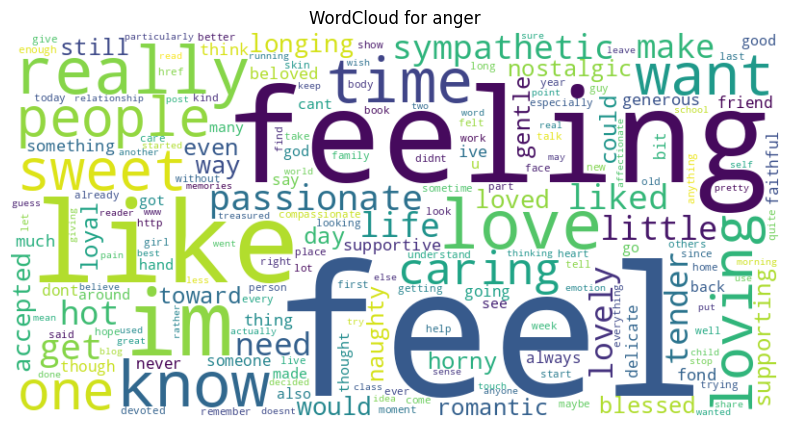

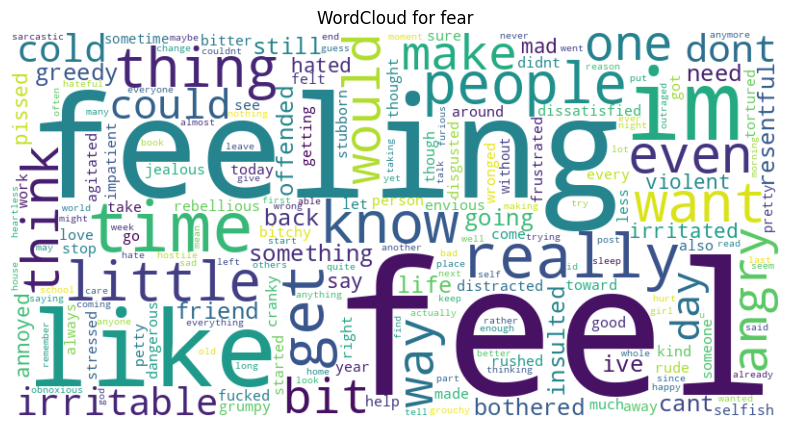

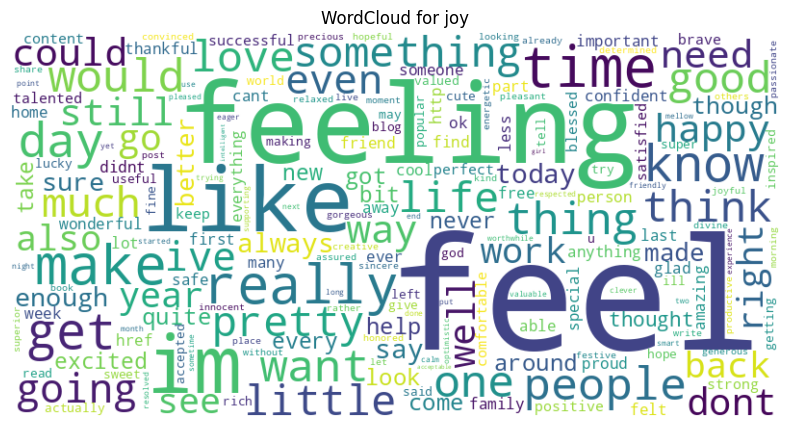

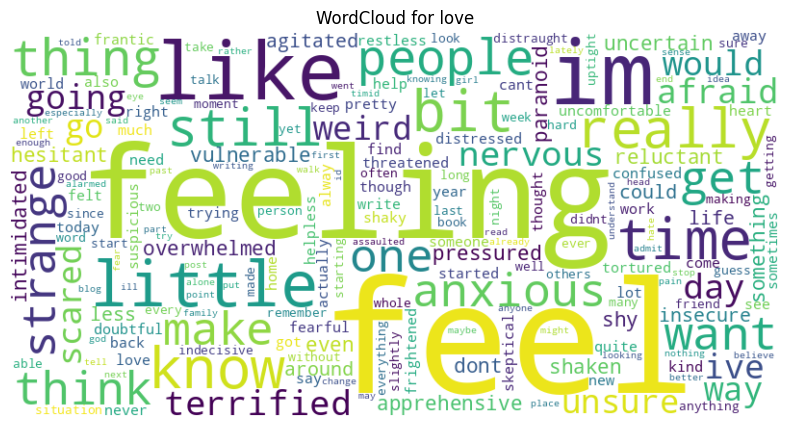

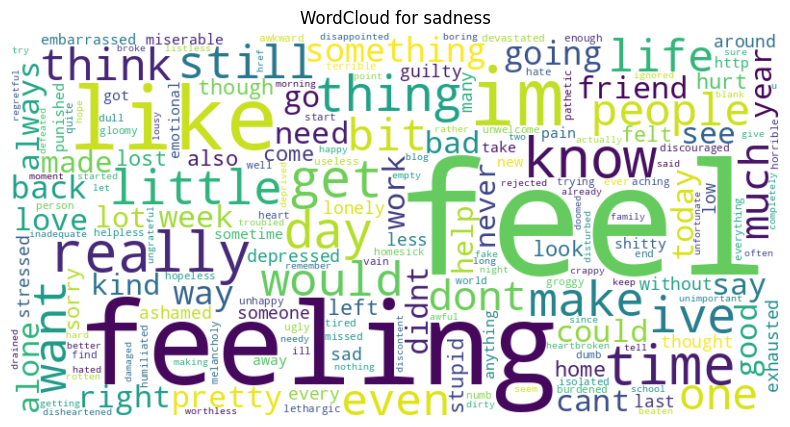

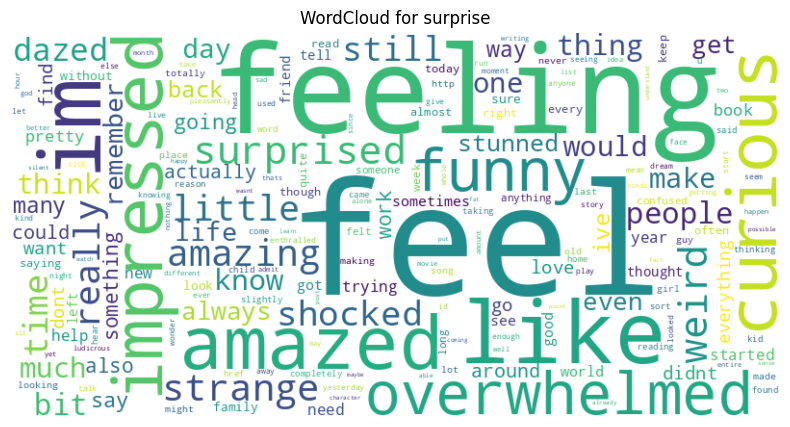

In [24]:
# wordcloud for each emotion category
for emo, subdf in emotion_groups.items():
    # combine all text in this emotion
    text = " ".join(subdf['text'].astype(str))
    # generate wordcloud
    wc = WordCloud(width=800, height=400, background_color='white',
                   stopwords=stop_words, collocations=False).generate(text)
    # plot
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {emo}")
    plt.show()

In [25]:
# computing the top 20 frequent tokens for each emotion
top_tokens_per_emotion = {}

for emo, subdf in emotion_groups.items():
    all_tokens = []
    for text in subdf['text']:
        tokens = [t.lower() for t in word_tokenize(str(text)) if t.isalpha() and t.lower() not in stop_words]
        all_tokens.extend(tokens)
    counter = Counter(all_tokens)
    top20 = [token for token, freq in counter.most_common(20)]
    top_tokens_per_emotion[emo] = top20
    print(f"Top 20 tokens for {emo}: {top20}")

Top 20 tokens for anger: ['feel', 'feeling', 'like', 'im', 'love', 'really', 'know', 'sweet', 'loving', 'time', 'want', 'people', 'caring', 'passionate', 'one', 'sympathetic', 'life', 'liked', 'get', 'hot']
Top 20 tokens for fear: ['feel', 'feeling', 'like', 'im', 'really', 'get', 'know', 'people', 'time', 'little', 'want', 'even', 'would', 'think', 'angry', 'things', 'bit', 'way', 'one', 'could']
Top 20 tokens for joy: ['feel', 'feeling', 'like', 'im', 'really', 'time', 'know', 'get', 'make', 'people', 'would', 'want', 'one', 'good', 'something', 'little', 'think', 'pretty', 'life', 'love']
Top 20 tokens for love: ['feel', 'feeling', 'im', 'like', 'little', 'bit', 'know', 'really', 'still', 'time', 'people', 'want', 'strange', 'anxious', 'get', 'terrified', 'nervous', 'think', 'going', 'one']
Top 20 tokens for sadness: ['feel', 'feeling', 'like', 'im', 'really', 'know', 'get', 'ive', 'little', 'time', 'would', 'still', 'want', 'even', 'life', 'bit', 'people', 'think', 'one', 'things']

In [26]:
# constructing a vocabulary of all top 20 tokens across emotions
top20_vocab = set()
for tokens in top_tokens_per_emotion.values():
    top20_vocab.update(tokens)

top20_vocab = sorted(top20_vocab)  # sort for consistency
print(f"Vocabulary of top 20 tokens across all categories (size={len(top20_vocab)}):")
print(top20_vocab)

Vocabulary of top 20 tokens across all categories (size=50):
['amazed', 'amazing', 'angry', 'anxious', 'bit', 'caring', 'could', 'curious', 'dazed', 'even', 'feel', 'feeling', 'funny', 'get', 'going', 'good', 'hot', 'im', 'impressed', 'ive', 'know', 'life', 'like', 'liked', 'little', 'love', 'loving', 'make', 'nervous', 'one', 'overwhelmed', 'passionate', 'people', 'pretty', 'really', 'shocked', 'something', 'still', 'strange', 'surprised', 'sweet', 'sympathetic', 'terrified', 'things', 'think', 'time', 'want', 'way', 'weird', 'would']


In [30]:
# building a frequency vector for each emotion in the top20_vocab space
freq_vectors = {}

for emo, subdf in emotion_groups.items():
    counter = Counter()
    for text in subdf['text']:
        tokens = [t.lower() for t in word_tokenize(str(text)) if t.isalpha()]
        counter.update(tokens)

    # only keep frequencies for tokens in top20_vocab
    vector = [counter.get(token, 0) for token in top20_vocab]
    freq_vectors[emo] = vector

# correlation matrix
emotions = list(freq_vectors.keys())
n = len(emotions)
corr_matrix = pd.DataFrame(np.zeros((n, n)), index=emotions, columns=emotions)

for i, emo1 in enumerate(emotions):
    for j, emo2 in enumerate(emotions):
        corr, _ = pearsonr(freq_vectors[emo1], freq_vectors[emo2])
        corr_matrix.loc[emo1, emo2] = round(corr, 3)

print("=== Pearson Correlation Matrix ===")
display(corr_matrix)


=== Pearson Correlation Matrix ===


,anger,fear,joy,love,sadness,surprise
anger,1.000,0.977,0.986,0.949,0.982,0.894
fear,0.977,1.000,0.991,0.984,0.997,0.927
joy,0.986,0.991,1.000,0.969,0.996,0.925
love,0.949,0.984,0.969,1.000,0.982,0.932
sadness,0.982,0.997,0.996,0.982,1.000,0.932
surprise,0.894,0.927,0.925,0.932,0.932,1.000


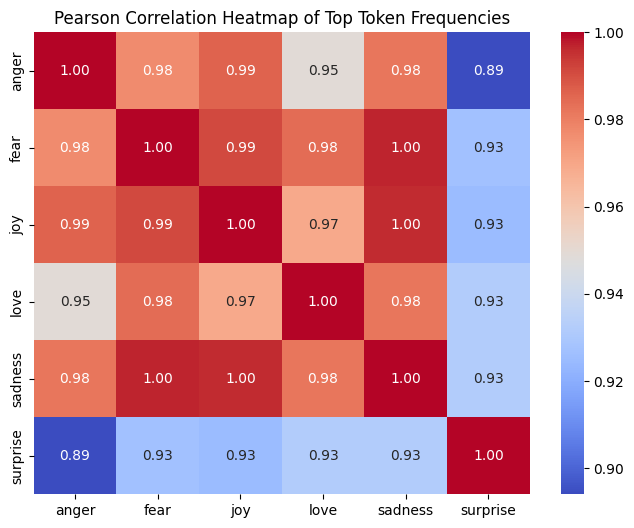

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson Correlation Heatmap of Top Token Frequencies")
plt.show()

# Task 3

In [35]:
lexicon = Empath()

In [37]:
# Compute Empath feature vector for each emotion (rows = emotion, cols = empath categories)

empath_vectors = {}

for emo, subdf in emotion_groups.items():
    text = " ".join(subdf['text'].astype(str))
    features = lexicon.analyze(text, normalize=True)
    empath_vectors[emo] = features

# Convert to DataFrame
empath_df = pd.DataFrame.from_dict(empath_vectors, orient='index').fillna(0.0)
print("Empath df shape (emotions x categories):", empath_df.shape)
display(empath_df.head())

Empath df shape (emotions x categories): (6, 194)


,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
anger,0.004405,0.001153,0.001242,0.001537,0.006268,0.003134,0.002247,0.000828,0.036601,0.016113,...,0.000443,0.011885,0.000118,0.001005,0.006623,0.050467,0.003045,0.000710,0.026697,0.001596
fear,0.002781,0.001189,0.000882,0.001764,0.002953,0.002666,0.002915,0.001266,0.038184,0.031338,...,0.000575,0.007748,0.000767,0.000556,0.003721,0.052606,0.003126,0.000499,0.024644,0.000959
joy,0.002863,0.001508,0.001401,0.001698,0.005109,0.003205,0.003198,0.000921,0.039546,0.016362,...,0.000411,0.008177,0.000190,0.000784,0.005261,0.053829,0.003883,0.000700,0.028117,0.002406
love,0.002878,0.001304,0.001169,0.001686,0.002001,0.002945,0.002451,0.001664,0.034084,0.023517,...,0.000427,0.009128,0.000135,0.000697,0.002968,0.054589,0.003912,0.000360,0.027677,0.001484
sadness,0.002323,0.001077,0.001096,0.001349,0.002960,0.003335,0.004328,0.001490,0.039882,0.028761,...,0.000412,0.007963,0.000197,0.000506,0.003448,0.056792,0.002886,0.001218,0.025689,0.001199


In [38]:
# top 8 Empath categories

top8_categories = empath_df.var(axis=0).sort_values(ascending=False).head(8).index.tolist()
print("Selected top-8 Empath categories:", top8_categories)

empath_top8_df = empath_df[top8_categories].copy()
print("Top8 df shape:", empath_top8_df.shape)
display(empath_top8_df.round(4))

Selected top-8 Empath categories: ['confusion', 'emotional', 'timidity', 'negative_emotion', 'hate', 'nervousness', 'love', 'affection']
Top8 df shape: (6, 8)


,confusion,emotional,timidity,negative_emotion,hate,nervousness,love,affection
anger,0.0010,0.0051,0.0046,0.0077,0.0161,0.0501,0.0507,0.0342
fear,0.0033,0.0226,0.0028,0.0219,0.0313,0.0535,0.0374,0.0197
joy,0.0009,0.0027,0.0013,0.0066,0.0164,0.0537,0.0426,0.0206
love,0.0188,0.0069,0.0214,0.0210,0.0235,0.0668,0.0364,0.0228
sadness,0.0021,0.0129,0.0027,0.0217,0.0288,0.0579,0.0417,0.0205
surprise,0.0158,0.0030,0.0049,0.0172,0.0197,0.0521,0.0361,0.0208


In [39]:
emotions = empath_top8_df.index.tolist()
n = len(emotions)
pearson_mat = pd.DataFrame(np.nan, index=emotions, columns=emotions, dtype=float)

for i, e1 in enumerate(emotions):
    v1 = empath_top8_df.loc[e1].values.astype(float)
    for j, e2 in enumerate(emotions):
        v2 = empath_top8_df.loc[e2].values.astype(float)
        if np.isclose(v1.std(), 0.0) or np.isclose(v2.std(), 0.0):
            pearson = np.nan
        else:
            pearson, _ = pearsonr(v1, v2)
        pearson_mat.loc[e1, e2] = round(pearson, 3) if not np.isnan(pearson) else np.nan

print("=== Pearson Correlation Matrix (Empath top-8 features) ===")
display(pearson_mat)

=== Pearson Correlation Matrix (Empath top-8 features) ===


,anger,fear,joy,love,sadness,surprise
anger,1.000,0.802,0.966,0.789,0.876,0.878
fear,0.802,1.000,0.888,0.765,0.977,0.833
joy,0.966,0.888,1.000,0.897,0.950,0.952
love,0.789,0.765,0.897,1.000,0.857,0.942
sadness,0.876,0.977,0.950,0.857,1.000,0.918
surprise,0.878,0.833,0.952,0.942,0.918,1.000


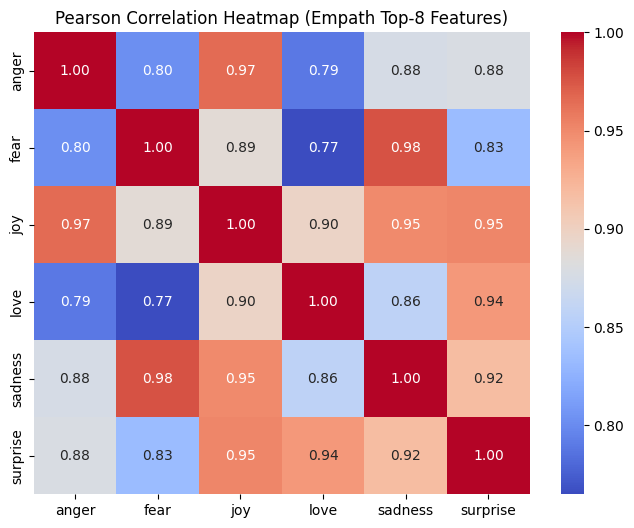

In [40]:
plt.figure(figsize=(8,6))
sns.heatmap(pearson_mat, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson Correlation Heatmap (Empath Top-8 Features)")
plt.show()

# Task 4

In [47]:
# for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [50]:
# tokenize texts per emotion

tokenized_emotions = {}
for emo, subdf in emotion_groups.items():
    tokenized_texts = []
    for text in subdf['text'].astype(str):
        toks = [t.lower() for t in word_tokenize(text) if t.isalpha()]
        toks = [t for t in toks if t not in stop_words]
        tokenized_texts.append(toks)
    tokenized_emotions[emo] = tokenized_texts


for emo, toks in tokenized_emotions.items():
    print(f"{emo}: {len(toks)} posts tokenized")


anger: 1641 posts tokenized
fear: 2709 posts tokenized
joy: 6761 posts tokenized
love: 2373 posts tokenized
sadness: 5797 posts tokenized
surprise: 719 posts tokenized


In [51]:
# train Word2Vec
all_sentences = []
for toks_lists in tokenized_emotions.values():
    all_sentences.extend(toks_lists)

w2v_model = Word2Vec(
    sentences=all_sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=SEED,
    epochs=10
)
print("Word2Vec vocab size:", len(w2v_model.wv))

Word2Vec vocab size: 8277


In [55]:
# word2vec embedding per emotion
emotion_embeddings = {}
for emo, token_lists in tokenized_emotions.items():
    vecs = []
    for tokens in token_lists:
        for t in tokens:
            if t in w2v_model.wv:
                vecs.append(w2v_model.wv[t])
    if len(vecs) > 0:
        emotion_embeddings[emo] = np.mean(vecs, axis=0)
    else:
        emotion_embeddings[emo] = np.zeros(w2v_model.vector_size)

# check shapes
for emo, v in emotion_embeddings.items():
    print(f"{emo}: {v.shape}")


anger: (100,)
fear: (100,)
joy: (100,)
love: (100,)
sadness: (100,)
surprise: (100,)


In [56]:
# PCA to 2D
emotion_names = list(emotion_embeddings.keys())
X = np.vstack([emotion_embeddings[emo] for emo in emotion_names])

pca = PCA(n_components=2, random_state=SEED)
X_2D = pca.fit_transform(X)

coords_df = pd.DataFrame(X_2D, index=emotion_names, columns=['PC1','PC2'])
print("2D PCA coordinates:\n", coords_df)

2D PCA coordinates:
                PC1       PC2
anger     0.166987  0.003392
fear     -0.028232  0.030519
joy       0.069508 -0.014825
love     -0.118912 -0.009022
sadness  -0.047433  0.030626
surprise -0.041917 -0.040689


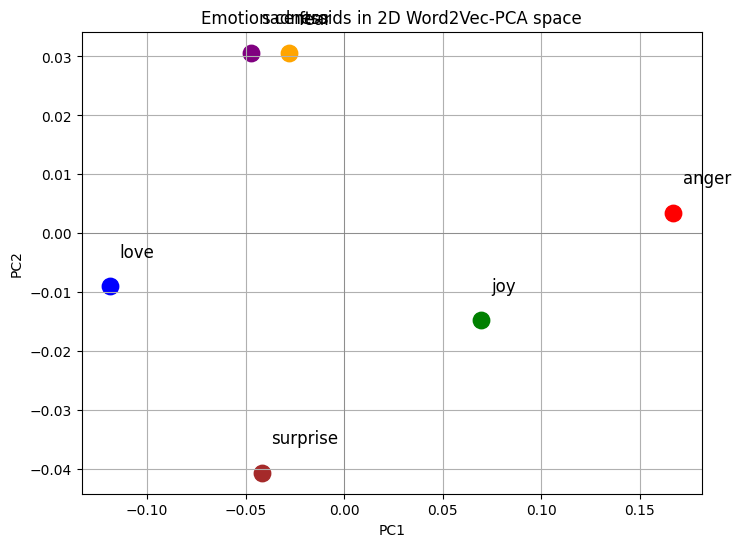

In [61]:
# plot the 2D coordinates and print pairwise distances
plt.figure(figsize=(8,6))
colors = ['red','orange','green','blue','purple','brown','cyan','magenta']  # >6 safe
for i, emo in enumerate(emotion_names):
    x, y = X_2D[i]
    plt.scatter(x, y, s=140, color=colors[i % len(colors)])
    plt.text(x+0.005, y+0.005, emo, fontsize=12)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Emotion centroids in 2D Word2Vec-PCA space')
plt.grid(True)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.show()

In [62]:
# pairwise cosine similarities & Euclidean distances

cos_sim = pd.DataFrame(cosine_similarity(X_2D), index=emotion_names, columns=emotion_names).round(3)

euclid = pd.DataFrame(squareform(pdist(X_2D, metric='euclidean')), index=emotion_names, columns=emotion_names).round(3)

print("Cosine similarity (2D coords):")
display(cos_sim)
print("Euclidean distances (2D coords):")
display(euclid)

Cosine similarity (2D coords):


,anger,fear,joy,love,sadness,surprise
anger,1.000,-0.664,0.974,-0.998,-0.829,-0.732
fear,-0.664,1.000,-0.817,0.622,0.969,-0.024
joy,0.974,-0.817,1.000,-0.959,-0.935,-0.556
love,-0.998,0.622,-0.959,1.000,0.797,0.768
sadness,-0.829,0.969,-0.935,0.797,1.000,0.225
surprise,-0.732,-0.024,-0.556,0.768,0.225,1.000


Euclidean distances (2D coords):


,anger,fear,joy,love,sadness,surprise
anger,0.000,0.197,0.099,0.286,0.216,0.214
fear,0.197,0.000,0.108,0.099,0.019,0.073
joy,0.099,0.108,0.000,0.189,0.125,0.114
love,0.286,0.099,0.189,0.000,0.082,0.083
sadness,0.216,0.019,0.125,0.082,0.000,0.072
surprise,0.214,0.073,0.114,0.083,0.072,0.000


# Task 5

In [65]:
# generating the 30 most similar words to each emotion using Word2Vec
top_n = 30
emotion_words = {}

for emo in emotion_names:
    if emo in w2v_model.wv:
        similar = w2v_model.wv.most_similar(emo, topn=top_n)
        top_words = [word for word, _ in similar]
        emotion_words[emo] = set(top_words)
    else:
        # If the emotion word itself is not in the vocabulary, skip
        emotion_words[emo] = set()


for emo, words in emotion_words.items():
    print(f"{emo}: {list(words)[:10]} ...")


anger: ['betrayed', 'offer', 'happiness', 'elegant', 'taste', 'tragic', 'charmed', 'looks', 'meant', 'ought'] ...
fear: ['betrayed', 'simple', 'offer', 'death', 'happiness', 'telling', 'taste', 'tragic', 'space', 'either'] ...
joy: ['appreciated', 'support', 'duty', 'divine', 'decisions', 'simply', 'expectation', 'speak', 'privileged', 'said'] ...
love: ['live', 'god', 'world', 'talk', 'family', 'show', 'part', 'make', 'someone', 'would'] ...
sadness: ['betrayed', 'socially', 'offer', 'abandoned', 'asking', 'taste', 'describe', 'looks', 'regret', 'fail'] ...
surprise: ['cost', 'career', 'public', 'term', 'brain', 'birth', 'teacher', 'artist', 'achieved', 'level'] ...


In [66]:
# function to compute Jaccard distance
def jaccard_distance(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if len(union) == 0:
        return 0  # avoid division by zero
    return 1 - len(intersection) / len(union)

# Compute Jaccard distance matrix
n = len(emotion_names)
jaccard_matrix = pd.DataFrame(np.zeros((n, n)), index=emotion_names, columns=emotion_names)

for i, emo1 in enumerate(emotion_names):
    for j, emo2 in enumerate(emotion_names):
        dist = jaccard_distance(emotion_words[emo1], emotion_words[emo2])
        jaccard_matrix.loc[emo1, emo2] = round(dist, 3)

print("=== Jaccard Distance Matrix (Top 30 Word2Vec neighbors) ===")
display(jaccard_matrix)

=== Jaccard Distance Matrix (Top 30 Word2Vec neighbors) ===


,anger,fear,joy,love,sadness,surprise
anger,0.000,0.750,1.0,1.0,0.824,1.0
fear,0.750,0.000,1.0,1.0,0.889,1.0
joy,1.000,1.000,0.0,1.0,1.000,1.0
love,1.000,1.000,1.0,0.0,1.000,1.0
sadness,0.824,0.889,1.0,1.0,0.000,1.0
surprise,1.000,1.000,1.0,1.0,1.000,0.0


In [67]:
# compute pairwise Euclidean distances in PCA 2D space
pca_distances = pd.DataFrame(np.zeros((n,n)), index=emotion_names, columns=emotion_names)

for i, emo1 in enumerate(emotion_names):
    for j, emo2 in enumerate(emotion_names):
        vec1 = X_2D[i]
        vec2 = X_2D[j]
        dist = np.linalg.norm(vec1 - vec2)
        pca_distances.loc[emo1, emo2] = round(dist, 3)

# Compare orderings: rank the distances for all pairs
pairs = list(combinations(emotion_names, 2))
pca_ranks = []
jaccard_ranks = []

for emo1, emo2 in pairs:
    pca_ranks.append((emo1, emo2, pca_distances.loc[emo1, emo2]))
    jaccard_ranks.append((emo1, emo2, jaccard_matrix.loc[emo1, emo2]))

# Convert to DataFrame and sort by distance
pca_ranks_df = pd.DataFrame(pca_ranks, columns=['emo1','emo2','pca_dist']).sort_values('pca_dist')
jaccard_ranks_df = pd.DataFrame(jaccard_ranks, columns=['emo1','emo2','jaccard_dist']).sort_values('jaccard_dist')

In [68]:
print("=== Pairwise distances ranked by PCA ===")
display(pca_ranks_df)

=== Pairwise distances ranked by PCA ===


,emo1,emo2,pca_dist
7,fear,sadness,0.019
14,sadness,surprise,0.072
8,fear,surprise,0.073
12,love,sadness,0.082
13,love,surprise,0.083
1,anger,joy,0.099
6,fear,love,0.099
5,fear,joy,0.108
11,joy,surprise,0.114
10,joy,sadness,0.125


In [69]:
print("=== Pairwise distances ranked by Jaccard ===")
display(jaccard_ranks_df)

=== Pairwise distances ranked by Jaccard ===


,emo1,emo2,jaccard_dist
0,anger,fear,0.750
3,anger,sadness,0.824
7,fear,sadness,0.889
1,anger,joy,1.000
2,anger,love,1.000
4,anger,surprise,1.000
5,fear,joy,1.000
6,fear,love,1.000
8,fear,surprise,1.000
9,joy,love,1.000


In [70]:
# Align distances for the same pairs
pca_values = pca_ranks_df['pca_dist'].values
jaccard_values = jaccard_ranks_df['jaccard_dist'].values

# Compute Spearman rank correlation
corr, _ = spearmanr(pca_values, jaccard_values)
print(f"Spearman rank correlation between PCA distances and Jaccard distances: {corr:.3f}")

Spearman rank correlation between PCA distances and Jaccard distances: 0.700


# Task 6

In [75]:
# train FastText embeddings
all_tokens = []
for tokens_list in tokenized_emotions.values():
    all_tokens.extend(tokens_list)

# Train FastText
fasttext_model = FastText(sentences=all_tokens, vector_size=100, window=5, min_count=1, workers=4)
print("FastText model trained.")

# Generate mean embedding per emotion
fasttext_embeddings = {}
for emo, token_lists in tokenized_emotions.items():
    vectors = []
    for tokens in token_lists:
        for t in tokens:
            vectors.append(fasttext_model.wv[t])
    fasttext_embeddings[emo] = np.mean(vectors, axis=0)

FastText model trained.


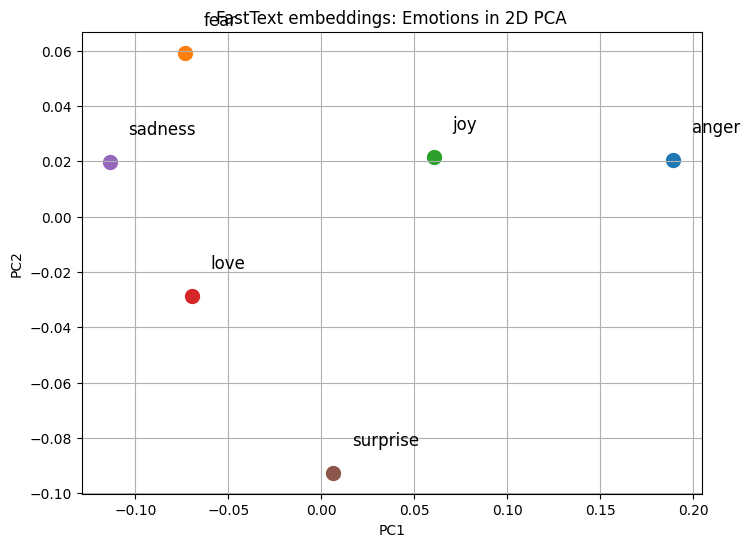

In [76]:
emotion_names = list(fasttext_embeddings.keys())
X_ft = np.array([fasttext_embeddings[emo] for emo in emotion_names])
pca = PCA(n_components=2)
X_ft_2D = pca.fit_transform(X_ft)

# Plot FastText
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
for i, emo in enumerate(emotion_names):
    plt.scatter(X_ft_2D[i,0], X_ft_2D[i,1], s=100)
    plt.text(X_ft_2D[i,0]+0.01, X_ft_2D[i,1]+0.01, emo, fontsize=12)
plt.title("FastText embeddings: Emotions in 2D PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [77]:
# Load GloVe (100d)
glove_model = KeyedVectors.load_word2vec_format("glove.6B.100d.word2vec.txt", binary=False)
print("GloVe model loaded.")

# Generate mean embedding per emotion using GloVe
glove_embeddings = {}
for emo, token_lists in tokenized_emotions.items():
    vectors = []
    for tokens in token_lists:
        for t in tokens:
            if t in glove_model:
                vectors.append(glove_model[t])
    glove_embeddings[emo] = np.mean(vectors, axis=0)

GloVe model loaded.


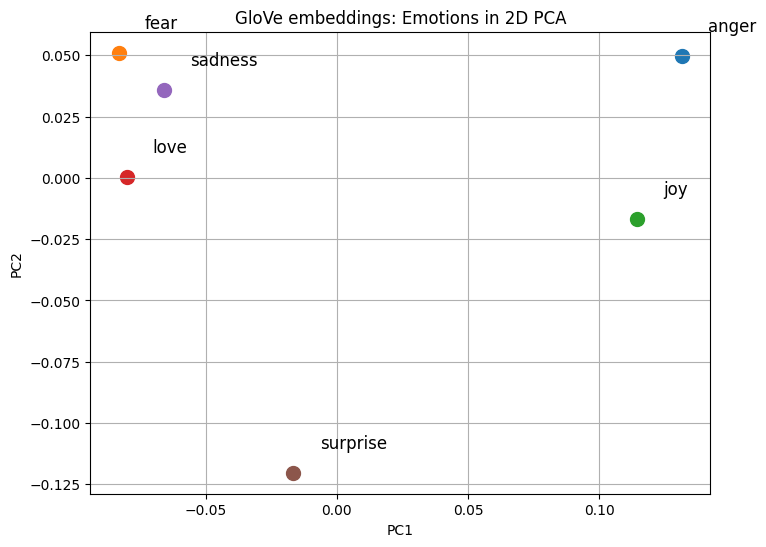

In [78]:
X_glove = np.array([glove_embeddings[emo] for emo in emotion_names])
X_glove_2D = PCA(n_components=2).fit_transform(X_glove)

plt.figure(figsize=(8,6))
for i, emo in enumerate(emotion_names):
    plt.scatter(X_glove_2D[i,0], X_glove_2D[i,1], s=100)
    plt.text(X_glove_2D[i,0]+0.01, X_glove_2D[i,1]+0.01, emo, fontsize=12)
plt.title("GloVe embeddings: Emotions in 2D PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [81]:
# Load RoBERTa
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModel.from_pretrained("roberta-base").to(device)
model.eval()  # inference mode

# Function to get embeddings in batches (GPU-optimized)
def batched_roberta_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128)

        # Send input tensors to GPU
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            outputs = model(**enc)

        # Mean pooling over token embeddings
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)

        # Move embeddings back to CPU before storing
        all_embeddings.append(batch_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0).numpy()

# Compute mean embedding per emotion
roberta_embeddings = {}
for emo, subdf in emotion_groups.items():  # emotion_groups = { 'anger': df_anger, ... }
    texts = subdf['text'].astype(str).tolist()
    print(f"Processing {emo}: {len(texts)} posts...")
    vecs = batched_roberta_embeddings(texts, batch_size=32)
    roberta_embeddings[emo] = np.mean(vecs, axis=0)

print("RoBERTa embeddings computed for all emotions.")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing anger: 1641 posts...
Processing fear: 2709 posts...
Processing joy: 6761 posts...
Processing love: 2373 posts...
Processing sadness: 5797 posts...
Processing surprise: 719 posts...
RoBERTa embeddings computed for all emotions.


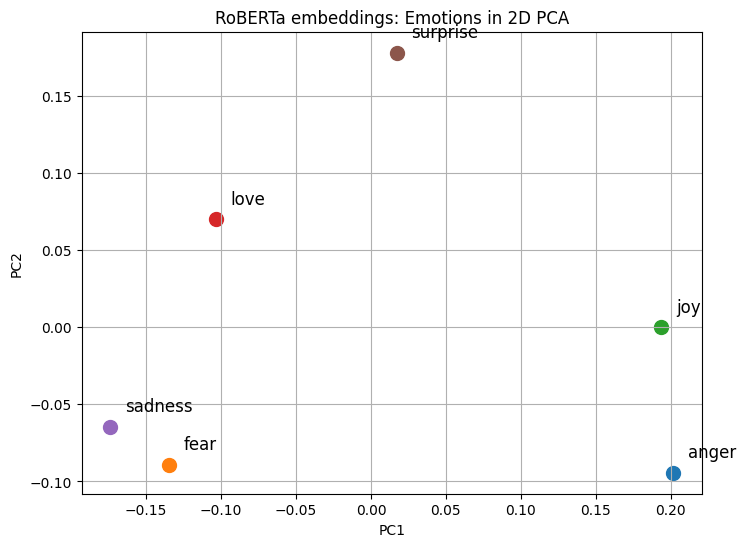

In [82]:
# Prepare matrix for PCA
emotion_names = list(roberta_embeddings.keys())
X_bert = np.array([roberta_embeddings[emo] for emo in emotion_names])

# PCA 2D projection
X_bert_2D = PCA(n_components=2).fit_transform(X_bert)

# Plot
plt.figure(figsize=(8,6))
for i, emo in enumerate(emotion_names):
    plt.scatter(X_bert_2D[i,0], X_bert_2D[i,1], s=100)
    plt.text(X_bert_2D[i,0]+0.01, X_bert_2D[i,1]+0.01, emo, fontsize=12)
plt.title("RoBERTa embeddings: Emotions in 2D PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Task 7

In [84]:
# Fine-tune Word2Vec & FastText

# Prepare all tokenized posts
all_tokens = []
for tokens_list in tokenized_emotions.values():
    all_tokens.extend(tokens_list)

# --- Word2Vec fine-tuning ---
w2v_model = Word2Vec(vector_size=100, window=5, min_count=1)
w2v_model.build_vocab(all_tokens)
w2v_model.train(all_tokens, total_examples=w2v_model.corpus_count, epochs=10)

# --- FastText fine-tuning ---
ft_model = FastText(vector_size=100, window=5, min_count=1)
ft_model.build_vocab(all_tokens)
ft_model.train(all_tokens, total_examples=ft_model.corpus_count, epochs=10)

print("Word2Vec and FastText fine-tuned on local dataset.")


Word2Vec and FastText fine-tuned on local dataset.


In [85]:
# Word2Vec embeddings per emotion
w2v_embeddings = {}
for emo, token_lists in tokenized_emotions.items():
    vecs = []
    for tokens in token_lists:
        for t in tokens:
            vecs.append(w2v_model.wv[t])
    w2v_embeddings[emo] = np.mean(vecs, axis=0)

In [86]:
# FastText embeddings per emotion
ft_embeddings = {}
for emo, token_lists in tokenized_emotions.items():
    vecs = []
    for tokens in token_lists:
        for t in tokens:
            vecs.append(ft_model.wv[t])
    ft_embeddings[emo] = np.mean(vecs, axis=0)

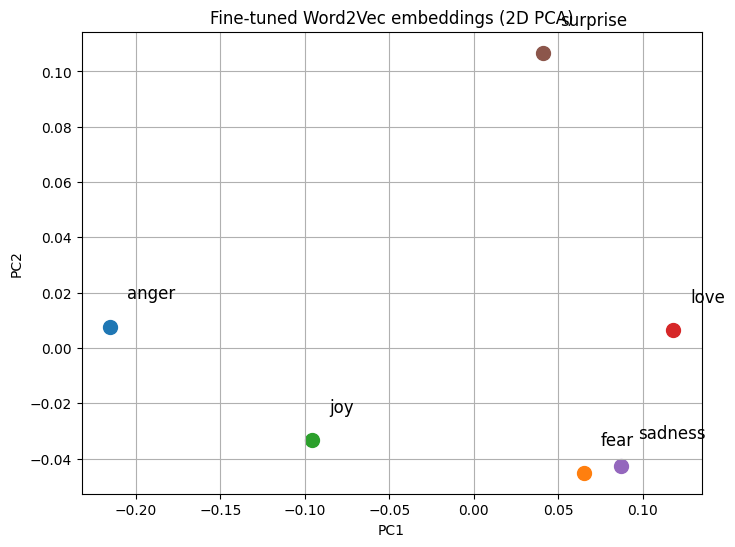

In [87]:
# Word2Vec 2D PCA
emotion_names = list(w2v_embeddings.keys())
X_w2v = np.array([w2v_embeddings[emo] for emo in emotion_names])
X_w2v_2D = PCA(n_components=2).fit_transform(X_w2v)

plt.figure(figsize=(8,6))
for i, emo in enumerate(emotion_names):
    plt.scatter(X_w2v_2D[i,0], X_w2v_2D[i,1], s=100)
    plt.text(X_w2v_2D[i,0]+0.01, X_w2v_2D[i,1]+0.01, emo, fontsize=12)
plt.title("Fine-tuned Word2Vec embeddings (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

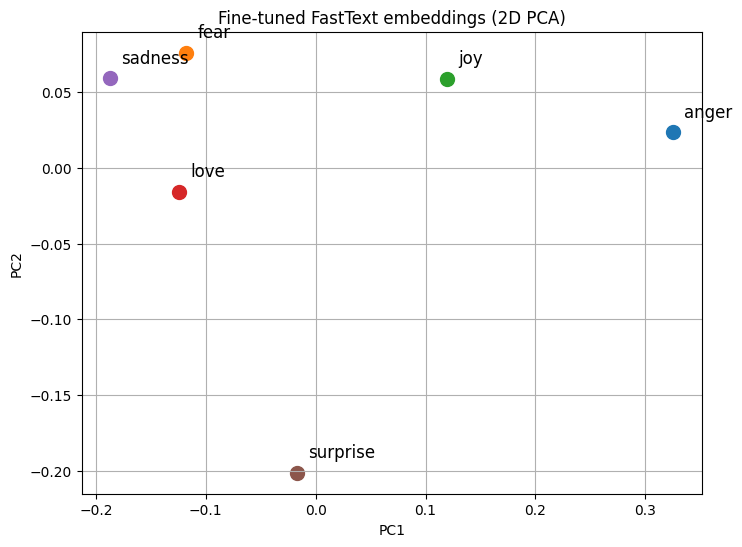

In [88]:
# FastText 2D PCA
X_ft = np.array([ft_embeddings[emo] for emo in emotion_names])
X_ft_2D = PCA(n_components=2).fit_transform(X_ft)

plt.figure(figsize=(8,6))
for i, emo in enumerate(emotion_names):
    plt.scatter(X_ft_2D[i,0], X_ft_2D[i,1], s=100)
    plt.text(X_ft_2D[i,0]+0.01, X_ft_2D[i,1]+0.01, emo, fontsize=12)
plt.title("Fine-tuned FastText embeddings (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [96]:
texts = []
labels = []

# Map emotions to numeric labels
label_map = {'sadness':0, 'joy':1, 'anger':2, 'fear':3, 'love':4, 'surprise':5}

for emo, subdf in emotion_groups.items():
    texts.extend(subdf['text'].astype(str).tolist())
    labels.extend([label_map[emo]]*len(subdf))

dataset = Dataset.from_dict({'text': texts, 'label': labels})

# ==========================
# Tokenizer + Model
# ==========================
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=6).to(device)

# ==========================
# Tokenization function
# ==========================
def tokenize_function(examples):
    # Pad to max_length to avoid batch size mismatch
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# ==========================
# Data collator for dynamic padding
# ==========================
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ==========================
# Training setup
# ==========================
training_args = TrainingArguments(
    output_dir="./roberta-finetuned",
    per_device_train_batch_size=16,
    num_train_epochs=1,
    save_strategy="no",
    logging_steps=50,
    fp16=True if device=='cuda' else False,
    report_to=[]  # disables W&B logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

# ==========================
# Train the model
# ==========================
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Step,Training Loss
50,1.477700
100,1.134700
150,0.706800
200,0.605900
250,0.463900
300,0.427500
350,0.407900
400,0.372200
450,0.388100
500,0.314500


TrainOutput(global_step=1250, training_loss=0.3965392837524414, metrics={'train_runtime': 176.6815, 'train_samples_per_second': 113.198, 'train_steps_per_second': 7.075, 'total_flos': 1315602524160000.0, 'train_loss': 0.3965392837524414, 'epoch': 1.0})

In [97]:
model.eval()
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [98]:
def batched_roberta_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        enc = {k:v.to(device) for k,v in enc.items()}
        with torch.no_grad():
            outputs = model.roberta(**enc)  # use RoBERTa backbone
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        all_embeddings.append(batch_embeddings.cpu())
    return torch.cat(all_embeddings, dim=0).numpy()

# Compute mean embedding per emotion
roberta_embeddings = {}
for emo, subdf in emotion_groups.items():
    texts = subdf['text'].astype(str).tolist()
    vecs = batched_roberta_embeddings(texts)
    roberta_embeddings[emo] = np.mean(vecs, axis=0)

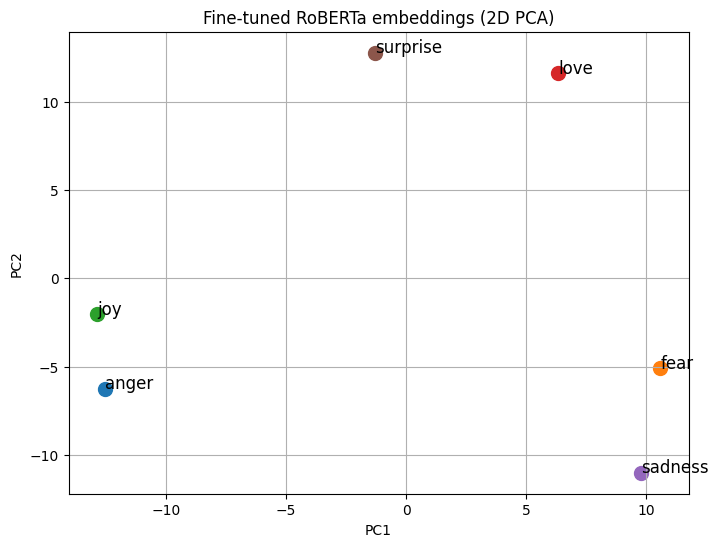

In [99]:
# PCA + plot
X_bert = np.array([roberta_embeddings[emo] for emo in emotion_names])
X_bert_2D = PCA(n_components=2).fit_transform(X_bert)

plt.figure(figsize=(8,6))
for i, emo in enumerate(emotion_names):
    plt.scatter(X_bert_2D[i,0], X_bert_2D[i,1], s=100)
    plt.text(X_bert_2D[i,0]+0.01, X_bert_2D[i,1]+0.01, emo, fontsize=12)
plt.title("Fine-tuned RoBERTa embeddings (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()